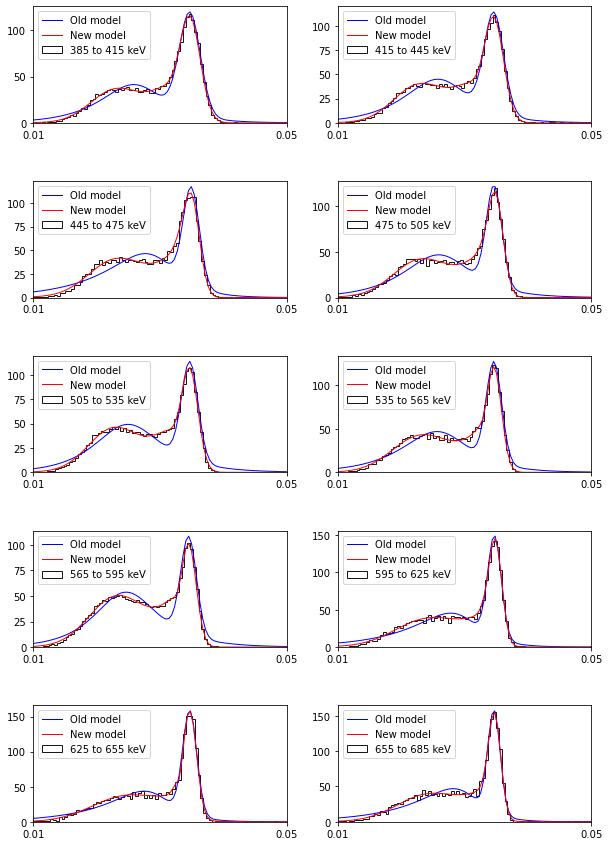

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from scipy import stats
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel, ConstantModel
from lmfit import Model

#------------------------------------------------------------------------------------------------------------------
df = pd.read_csv("data/run0113_git_det37_tier3_table.txt", sep=" ", header=0)
df.head()
l = len(df)
energy = df[df.columns[0]]
meanpeak = 0.03444373720763273 # 0.034723684138888884 #0.03444373720763273
AoE = df[df.columns[1]]#/meanpeak


#-------------------------------------------------------
A , B, w = 385, 415, 30           #start - end - energy window 
n = 500
binw = 0.00045     #bin width 0.008 , 0.0045, 0.002
#------------------------------- --------------------------------------------------------------- Models
def gauss(x, amp, center, sigma):
    return amp/(np.sqrt(2*np.pi))/sigma*(np.exp(-0.5*((x-center)/sigma)**2))
def tail(x, m, f, l, d, t):
    return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
def fexpo(x, f, a):
    return exp(f * x + a)
def totalfit(x, ampl, mu, std, m, f, l, t, ampl2, mu2, std2):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t) + gauss(x, ampl2, mu2, std2)
def totalfit_old(x, ampl, mu, std, m, f, l, t):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t)
#--------------------------------------------------------------------------------------------- Figure settings

#--------------------------------------------------------------------------------------------- Fitting parameters
chi = []
means = []
meanstot = []
stds  =  []
stdtot = []
xticks = []
centroid_list = []
#------------------------------------------------------- data extraction
for j in range(10):
    data = []
    for i in range(len(energy)):
        if energy[i] > A and energy[i]< B:
            data.append(AoE[i])
    xdata = np.asarray(data)
#-------------------------------------------------------
#------------------------------------------------------- bins and centroid
    b = len(np.arange(min(xdata), max(xdata) + binw, binw))
    y,x,_= axs[j].hist(xdata, \
                       bins = b, \
                       histtype=u'step', density=True, alpha=0.9, color='k', \
                       label='%.f to %.f keV' %(A, B))

    x = (x[1:]+x[:-1])/2    
    centroid = x[np.argmax(y)]
    centroid_list.append(centroid)
#-------------------------------------------------------
    
#------------------------------------------------------- Gaussian model        
    model1 = Model(gauss, prefix='g_')
    paramslm = model1.make_params(g_amp=len(xdata), g_center=centroid, g_sigma=centroid*0.01)
    paramslm['g_amp'].min = 0.
    paramslm['g_center'].min = centroid * 0.9
    paramslm['g_center'].max = centroid * 1.1
    paramslm['g_sigma'].min = 0
    paramslm['g_sigma'].max = 1
    
    result1 = model1.fit(y[(x>centroid*0.985) & (x<centroid*1.2)], paramslm, x=x[(x>centroid*0.985) & (x<centroid*1.2)])
    means.append(result1.params['g_center'].value)
    stds.append(result1.params['g_sigma'].value)
    xticks.append(A)

#-------------------------------------------------------EXTRAMODEL
    model4 = Model(gauss, prefix='e_')
    paramslm4 = model4.make_params(e_amp=len(xdata), e_center=centroid*0.6, e_sigma=centroid*0.01)
    paramslm4['e_amp'].min = 0.
    paramslm4['e_center'].min = centroid * 0.5
    paramslm4['e_center'].max = centroid * 0.9
    paramslm4['e_sigma'].min = 0
    paramslm4['e_sigma'].max = 1
    
    result4 = model4.fit(y[(x>centroid*0.1) & (x<centroid*0.9)], paramslm4, x=x[(x>centroid*0.1) & (x<centroid*0.9)])

#------------------------------------------------------- Expo
    model3 = Model(fexpo, prefix='e_') 
    paramslmex = model3.make_params(e_f=1, e_a=1)
    
    expo_min = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    expo_max = result1.params['g_center'].value - 4*result1.params['g_sigma'].value
    
    fmin = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    fmax = result1.params['g_center'].value + 10*result1.params['g_sigma'].value

    result3 = model3.fit(y[x>fmin], paramslmex, x=x[x>fmin])    
#-------------------------------------------------------

#------------------------------------------------------- The tail(from direct model)
    enteries = 0
    for i in range(len(xdata)):
        if (xdata[i] < result1.params['g_center'].value  - 3*result1.params['g_sigma'].value) & \
        (xdata[i] > result1.params['g_center'].value  - 25*result1.params['g_sigma'].value):
            enteries = enteries +1
    model2 = Model(tail, prefix='t_') 
    paramslm2 = model2.make_params(t_m= enteries * result1.params['g_center'].value, \
                              t_f= result3.params['e_f'].value, \
                              t_l= result1.params['g_center'].value - 1.2 * result1.params['g_sigma'].value, \
                              t_d= 0 ,\
                              t_t= 0.2 * result1.params['g_sigma'].value )
    paramslm2['t_d'].vary = False
    
    min_tail = result1.params['g_center'].value - 25 * result1.params['g_sigma'].value
    max_tail = result1.params['g_center'].value + 10 * result1.params['g_sigma'].value
    
    result2 = model2.fit(y[(x>min_tail) & (x<max_tail)], paramslm2, x=x[(x>min_tail) & (x<max_tail)])
#-------------------------------------------------------
    
    modeltot = Model(totalfit, prefix='tot_') 
    paramstot = modeltot.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value, \
                                     tot_ampl2=result4.params['e_amp'].value, \
                                     tot_mu2=result4.params['e_center'].value, \
                                     tot_std2=result4.params['e_sigma'].value)
    
    paramstot['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot['tot_m'].min  = 0
    paramstot['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot['tot_t'].min  = 0
    paramstot['tot_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    #resulttot = modeltot.fit(y, paramstot, x=x, weights=np.sqrt(1.0/np.std(AoE)))
    weight = 1/np.std(xdata)
    resulttot = modeltot.fit(y, paramstot, x=x)#, weights=weight)
    chi.append(resulttot.redchi)
    
    #------------------------
    modeltot_old = Model(totalfit_old, prefix='tot_') 
    paramstot_old = modeltot_old.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value)
    
    paramstot_old['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot_old['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot_old['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot_old['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot_old['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot_old['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot_old['tot_m'].min  = 0
    paramstot_old['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot_old['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot_old['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot_old['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot_old['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot_old['tot_t'].min  = 0
    paramstot_old['tot_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    #resulttot = modeltot.fit(y, paramstot, x=x, weights=np.sqrt(1.0/np.std(AoE)))
    weight = 1/np.std(xdata)
    resulttot_old = modeltot_old.fit(y, paramstot_old, x=x)#, weights=weight)

    #------------------------------------------------------- Total fit
    SSE = gauss(x, resulttot.params['tot_ampl'].value, resulttot.params['tot_mu'].value, resulttot.params['tot_std'].value)
    MSE = tail(x, resulttot.params['tot_m'].value, resulttot.params['tot_f'].value, \
               resulttot.params['tot_l'].value, 0, resulttot.params['tot_t'].value)
    plateau = gauss(x[(x>centroid*0.1) & (x<centroid*0.9)], result4.params['e_amp'].value, result4.params['e_center'].value, result4.params['e_sigma'].value)
#-------------------------------------------------------
#------------------------------------------------------- Plotting
#     axs[j].plot(x, SSE, color='r', lw=0.5)
#     axs[j].plot(x, MSE, color='b', lw=0.5)
#     axs[j].plot(x[(x>centroid*0.1) & (x<centroid*0.9)], plateau, color='violet', lw=0.5, label='Extra gaussian')
    axs[j].plot(x, resulttot_old.best_fit, color='b', lw=1, label='Old model')
    axs[j].plot(x, resulttot.best_fit, color='r', lw=1, label='New model')
    axs[j].legend(loc=2, prop={'size': 10})
    axs[j].set_xlim(0.01,0.05)
    #axs[j].set_xlim(0.02,0.06)
    axs[j].set_xticks([0.01,0.05])
    A = A + w
    B = B + w

#fig.suptitle('Inverted Coax det=37, run-0112 \n %.f keV window'%(w), fontsize=20)
#plt.savefig('from 100 to %.f keV (binw=%.4f).pdf'%(B,binw))
plt.savefig('new_plots/IC2_run0113_2_(355-%.f).pdf'%(B))
#print(chi)


In [ ]:
# To NORMALIZE AOE
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from scipy import stats
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel, ConstantModel
from lmfit import Model

#bin = 0.007
#[55, 85, 115, 145, 175, 205, 235, 265, 295, 325, 355, 385, 415, 445, 475, 505, 535, 565, 595, 625]
#SINGLE SLICE


#------------------------------------------------------------------------------------------------------------------
df = pd.read_csv("data/run0113_git_det37_tier3_table.txt", sep=" ", header=0)
df.head()
l = len(df)
energy = df[df.columns[0]]
meanpeak = 0.03449125395450946
AoE = df[df.columns[1]]#/meanpeak

data = []
A , B, w = 325, 355, 30           #start - end - energy window  

for j in range(1):
    for i in range(len(energy)):
        if energy[i] > A and energy[i]< B:
            data.append(AoE[i])
xdata = np.asarray(data)
    
#-------------------------------------------------------

#---------------------------------------------------------------------------------------------- Models
def gauss(x, amp, center, sigma):
    return amp/(np.sqrt(2*np.pi))/sigma*(np.exp(-0.5*((x-center)/sigma)**2))
def tail(x, m, f, l, d, t):
    return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
def fexpo(x, f, a):
    return exp(f * x + a)
def totalfit(x, ampl, mu, std, m, f, l, t):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t)
#--------------------------------------------------------------------------------------------- Figure settings
fig = plt.figure(figsize=(12,6))
#------------------------------------------------------- bins and centroid
n = 200
binw = 0.00004      #bin width 0.008
#binw = freedman(data=xdata, returnas="width")
b = len(np.arange(min(xdata), max(xdata) + binw, binw))
y,x,_= hist(xdata, \
                   bins = b, \
                   histtype=u'step', density=True, alpha=0.4, color='grey', label='%.f - %.f keV'%(A,B))

x = (x[1:]+x[:-1])/2    
centroid = x[np.argmax(y)]
print(len(xdata))
#------------------------------------------------------- Gaussian model        
model1 = Model(gauss, prefix='g_')
paramslm = model1.make_params(g_amp=len(xdata), g_center=centroid, g_sigma=centroid*0.01)
paramslm['g_amp'].min = 0.
paramslm['g_center'].min = centroid * 0.9
paramslm['g_center'].max = centroid * 1.1
paramslm['g_sigma'].min = 0
paramslm['g_sigma'].max = 1
result1 = model1.fit(y[(x>centroid*0.985) & (x<centroid*1.2)], paramslm, x=x[(x>centroid*0.985) & (x<centroid*1.2)])
#------------------------------------------------------- Expo
model3 = Model(fexpo, prefix='e_') 
paramslmex = model3.make_params(e_f=1, e_a=1)
expo_min = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
expo_max = result1.params['g_center'].value - 4*result1.params['g_sigma'].value
fmin = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
fmax = result1.params['g_center'].value + 10*result1.params['g_sigma'].value
result3 = model3.fit(y[x>fmin], paramslmex, x=x[x>fmin],  weights=np.sqrt(1.0/np.std(AoE)))    
#------------------------------------------------------- The tail(from direct model)
enteries = 0
for i in range(len(AoE)):
    if (AoE[i] < result1.params['g_center'].value  - 3*result1.params['g_sigma'].value) & \
    (AoE[i] > result1.params['g_center'].value  - 25*result1.params['g_sigma'].value):
        enteries = enteries +1
model2 = Model(tail, prefix='t_') 
paramslm2 = model2.make_params(t_m= enteries * result1.params['g_center'].value, \
                               t_f = result3.params['e_f'].value, \
                               t_l = result1.params['g_center'].value - 1.5 * result1.params['g_sigma'].value, \
                               t_d = 0 ,\
                               t_t = 0.2 * result1.params['g_sigma'].value )
paramslm2['t_d'].vary = False
 
min_tail = result1.params['g_center'].value - 25 * result1.params['g_sigma'].value
max_tail = result1.params['g_center'].value + 0 * result1.params['g_sigma'].value
result2 = model2.fit(y[(x>min_tail) & (x<max_tail)], paramslm2, x=x[(x>min_tail) & (x<max_tail)],  weights=np.sqrt(1.0/np.std(AoE)))
#-------------------------------------------------------
modeltot = Model(totalfit, prefix='tot_') 
paramstot = modeltot.make_params(tot_ampl=result1.params['g_amp'].value, \
                                 tot_mu = result1.params['g_center'].value, \
                                 tot_std = result1.params['g_sigma'].value, \
                                 tot_m = result2.params['t_m'].value, \
                                 tot_f = result2.params['t_f'].value, \
                                 tot_l = result2.params['t_l'].value, \
                                 tot_t = result2.params['t_t'].value)
    
paramstot['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
paramstot['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

paramstot['tot_mu'].min  = 0.995 * result1.params['g_center'].value
paramstot['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
paramstot['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
paramstot['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
paramstot['tot_m'].min  = 0
paramstot['tot_m'].max  = 10 * result2.params['t_m'].value
    
paramstot['tot_f'].min  = 0.2 * result2.params['t_f'].value
paramstot['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
paramstot['tot_l'].min  = 0.5 * result2.params['t_l'].value
paramstot['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
paramstot['tot_t'].min  = 0
paramstot['tot_t'].max  = 2.0 * result1.params['g_sigma'].value

resulttot = modeltot.fit(y, paramstot, x=x,  weights=np.sqrt(1.0/np.std(AoE)))
#------------------------------------------------------- Total fit
SSE = gauss(x, resulttot.params['tot_ampl'].value, resulttot.params['tot_mu'].value, resulttot.params['tot_std'].value)
MSE = tail(x, resulttot.params['tot_m'].value, resulttot.params['tot_f'].value, \
           resulttot.params['tot_l'].value, 0, resulttot.params['tot_t'].value)
#-------------------------------------------------------
#------------------------------------------------------- Plotting
plt.plot(x, SSE, color='b', lw=0.5)
plt.plot(x, MSE, color='g', lw=0.5)
plt.plot(x, resulttot.best_fit, color='r', lw=1)
plt.plot([], [], ' ', label="IC50B")
plt.legend(loc=2, prop={'size': 20}, frameon=False)
plt.xlim(0.01,0.05)
plt.xlabel('A/E [a.u.]')
plt.ylabel('counts [a.u.]')

#plt.savefig('IC50B-%.f-%.f.pdf'%(A,B))

print(resulttot.fit_report() )


41396


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from scipy import stats
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel, ConstantModel
from lmfit import Model

#------------------------------------------------------------------------------------------------------------------
df = pd.read_csv("data/run0113_git_det37_tier3_table.txt", sep=" ", header=0)
df.head()
l = len(df)
energy = df[df.columns[0]]
meanpeak = 0.03444373720763273 # 0.034723684138888884 #0.03444373720763273
AoE = df[df.columns[1]]#/meanpeak


#-------------------------------------------------------
A , B, w = 115, 145, 30           #start - end - energy window 
n = 500
binw = 0.00045     #bin width 0.008 , 0.0045, 0.002
#------------------------------- --------------------------------------------------------------- Models
def gauss(x, amp, center, sigma):
    return amp/(np.sqrt(2*np.pi))/sigma*(np.exp(-0.5*((x-center)/sigma)**2))
def tail(x, m, f, l, d, t):
    return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
def fexpo(x, f, a):
    return exp(f * x + a)
def totalfit(x, ampl, mu, std, m, f, l, t, ampl2, mu2, std2):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t) + gauss(x, ampl2, mu2, std2)
def totalfit_old(x, ampl, mu, std, m, f, l, t):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t)
#--------------------------------------------------------------------------------------------- Figure settings
fig, axs = plt.subplots(5,2, figsize=(10,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace = 0.2)
axs = axs.ravel()
#--------------------------------------------------------------------------------------------- Fitting parameters
chi = []
means = []
meanstot = []
stds  =  []
stdtot = []
xticks = []
centroid_list = []
#------------------------------------------------------- data extraction
for j in range(10):
    data = []
    for i in range(len(energy)):
        if energy[i] > A and energy[i]< B:
            data.append(AoE[i])
    xdata = np.asarray(data)
#-------------------------------------------------------
#------------------------------------------------------- bins and centroid
    b = len(np.arange(min(xdata), max(xdata) + binw, binw))
    y,x,_= axs[j].hist(xdata, \
                       bins = b, \
                       histtype=u'step', density=True, alpha=0.5, color='orange', \
                       label='%.f to %.f keV' %(A, B))

    x = (x[1:]+x[:-1])/2    
    centroid = x[np.argmax(y)]
    centroid_list.append(centroid)
#-------------------------------------------------------
    
#------------------------------------------------------- Gaussian model        
    model1 = Model(gauss, prefix='g_')
    paramslm = model1.make_params(g_amp=len(xdata), g_center=centroid, g_sigma=centroid*0.01)
    paramslm['g_amp'].min = 0.
    paramslm['g_center'].min = centroid * 0.9
    paramslm['g_center'].max = centroid * 1.1
    paramslm['g_sigma'].min = 0
    paramslm['g_sigma'].max = 1
    
    result1 = model1.fit(y[(x>centroid*0.985) & (x<centroid*1.2)], paramslm, x=x[(x>centroid*0.985) & (x<centroid*1.2)])
    means.append(result1.params['g_center'].value)
    stds.append(result1.params['g_sigma'].value)
    xticks.append(A)

#-------------------------------------------------------EXTRAMODEL
    model4 = Model(gauss, prefix='e_')
    paramslm4 = model4.make_params(e_amp=len(xdata), e_center=centroid*0.6, e_sigma=centroid*0.01)
    paramslm4['e_amp'].min = 0.
    paramslm4['e_center'].min = centroid * 0.5
    paramslm4['e_center'].max = centroid * 0.9
    paramslm4['e_sigma'].min = 0
    paramslm4['e_sigma'].max = 1
    
    result4 = model4.fit(y[(x>centroid*0.1) & (x<centroid*0.9)], paramslm4, x=x[(x>centroid*0.1) & (x<centroid*0.9)])

#------------------------------------------------------- Expo
    model3 = Model(fexpo, prefix='e_') 
    paramslmex = model3.make_params(e_f=1, e_a=1)
    
    expo_min = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    expo_max = result1.params['g_center'].value - 4*result1.params['g_sigma'].value
    
    fmin = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    fmax = result1.params['g_center'].value + 10*result1.params['g_sigma'].value

    result3 = model3.fit(y[x>fmin], paramslmex, x=x[x>fmin])    
#-------------------------------------------------------

#------------------------------------------------------- The tail(from direct model)
    enteries = 0
    for i in range(len(xdata)):
        if (xdata[i] < result1.params['g_center'].value  - 3*result1.params['g_sigma'].value) & \
        (xdata[i] > result1.params['g_center'].value  - 25*result1.params['g_sigma'].value):
            enteries = enteries +1
    model2 = Model(tail, prefix='t_') 
    paramslm2 = model2.make_params(t_m= enteries * result1.params['g_center'].value, \
                              t_f= result3.params['e_f'].value, \
                              t_l= result1.params['g_center'].value - 1.2 * result1.params['g_sigma'].value, \
                              t_d= 0 ,\
                              t_t= 0.2 * result1.params['g_sigma'].value )
    paramslm2['t_d'].vary = False
    
    min_tail = result1.params['g_center'].value - 25 * result1.params['g_sigma'].value
    max_tail = result1.params['g_center'].value + 10 * result1.params['g_sigma'].value
    
    result2 = model2.fit(y[(x>min_tail) & (x<max_tail)], paramslm2, x=x[(x>min_tail) & (x<max_tail)])
#-------------------------------------------------------
    
    modeltot = Model(totalfit, prefix='tot_') 
    paramstot = modeltot.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value, \
                                     tot_ampl2=result4.params['e_amp'].value, \
                                     tot_mu2=result4.params['e_center'].value, \
                                     tot_std2=result4.params['e_sigma'].value)
    
    paramstot['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot['tot_m'].min  = 0
    paramstot['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot['tot_t'].min  = 0
    paramstot['tot_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    #resulttot = modeltot.fit(y, paramstot, x=x, weights=np.sqrt(1.0/np.std(AoE)))
    weight = 1/np.std(xdata)
    resulttot = modeltot.fit(y, paramstot, x=x)#, weights=weight)
    chi.append(resulttot.redchi)
    
    #------------------------
    modeltot_old = Model(totalfit_old, prefix='tot_') 
    paramstot_old = modeltot_old.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value)
    
    paramstot_old['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot_old['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot_old['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot_old['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot_old['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot_old['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot_old['tot_m'].min  = 0
    paramstot_old['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot_old['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot_old['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot_old['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot_old['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot_old['tot_t'].min  = 0
    paramstot_old['tot_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    #resulttot = modeltot.fit(y, paramstot, x=x, weights=np.sqrt(1.0/np.std(AoE)))
    weight = 1/np.std(xdata)
    resulttot_old = modeltot_old.fit(y, paramstot_old, x=x)#, weights=weight)

    #------------------------------------------------------- Total fit
    SSE = gauss(x, resulttot.params['tot_ampl'].value, resulttot.params['tot_mu'].value, resulttot.params['tot_std'].value)
    MSE = tail(x, resulttot.params['tot_m'].value, resulttot.params['tot_f'].value, \
               resulttot.params['tot_l'].value, 0, resulttot.params['tot_t'].value)
    plateau = gauss(x[(x>centroid*0.1) & (x<centroid*0.9)], result4.params['e_amp'].value, result4.params['e_center'].value, result4.params['e_sigma'].value)
#-------------------------------------------------------
#------------------------------------------------------- Plotting
#     axs[j].plot(x, SSE, color='r', lw=0.5)
#     axs[j].plot(x, MSE, color='b', lw=0.5)
#     axs[j].plot(x[(x>centroid*0.1) & (x<centroid*0.9)], plateau, color='violet', lw=0.5, label='Extra gaussian')
    axs[j].plot(x, resulttot_old.best_fit, color='b', lw=1, label='Old model')
    axs[j].plot(x, resulttot.best_fit, color='r', lw=1, label='New model')
    axs[j].legend(loc=2, prop={'size': 7})
    axs[j].set_xlim(0.01,0.05)
    #axs[j].set_xlim(0.02,0.06)
    axs[j].set_xticks([0.01,0.05])
    A = A + w
    B = B + w

#fig.suptitle('Inverted Coax det=37, run-0112 \n %.f keV window'%(w), fontsize=20)
#plt.savefig('from 100 to %.f keV (binw=%.4f).pdf'%(B,binw))
# plt.savefig('new_plots/IC2_run0113_(385-%.f)(50keV).pdf'%(B))
#print(chi)


<ipython-input-6-4445b8c4f8df>:27: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)


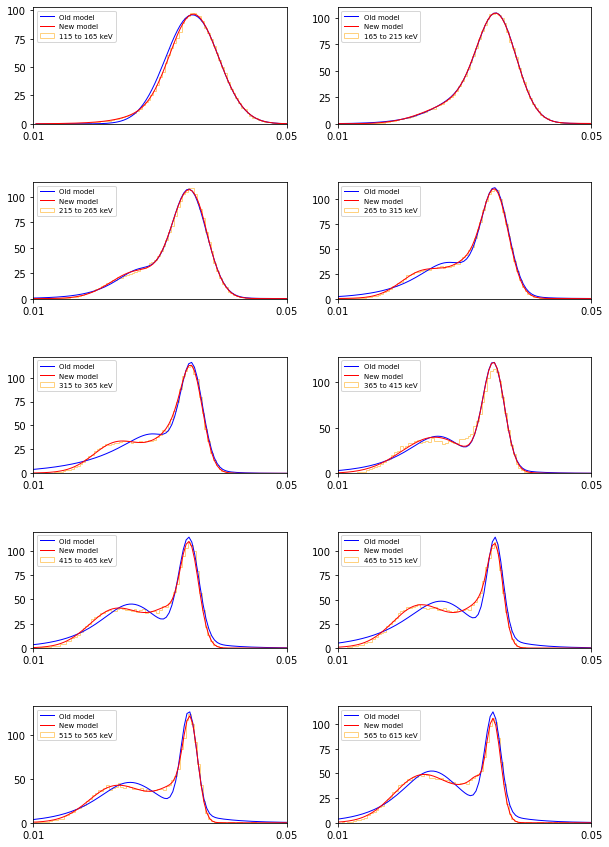

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from scipy import stats
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel, ConstantModel
from lmfit import Model

#------------------------------------------------------------------------------------------------------------------
df = pd.read_csv("data/run0113_git_det37_tier3_table.txt", sep=" ", header=0)
df.head()
l = len(df)
energy = df[df.columns[0]]
meanpeak = 0.03444373720763273 # 0.034723684138888884 #0.03444373720763273
AoE = df[df.columns[1]]#/meanpeak


#-------------------------------------------------------
A , B, w = 205, 235, 30           #start - end - energy window 
n = 500
binw = 0.00045     #bin width 0.008 , 0.0045, 0.002
#------------------------------- --------------------------------------------------------------- Models
def gauss(x, amp, center, sigma):
    return amp/(np.sqrt(2*np.pi))/sigma*(np.exp(-0.5*((x-center)/sigma)**2))
def tail(x, m, f, l, d, t):
    return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
def fexpo(x, f, a):
    return exp(f * x + a)
def totalfit(x, ampl, mu, std, m, f, l, t, ampl2, mu2, std2):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t) + gauss(x, ampl2, mu2, std2)
def totalfit_old(x, ampl, mu, std, m, f, l, t):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t)
#--------------------------------------------------------------------------------------------- Figure settings
fig, axs = plt.subplots(5,2, figsize=(10,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace = 0.2)
axs = axs.ravel()
#--------------------------------------------------------------------------------------------- Fitting parameters
chi = []
means = []
meanstot = []
stds  =  []
stdtot = []
xticks = []
centroid_list = []
#------------------------------------------------------- data extraction
for j in range(10):
    data = []
    for i in range(len(energy)):
        if energy[i] > A and energy[i]< B:
            data.append(AoE[i])
    xdata = np.asarray(data)
#-------------------------------------------------------
#------------------------------------------------------- bins and centroid
    b = len(np.arange(min(xdata), max(xdata) + binw, binw))
    y,x,_= axs[j].hist(xdata, \
                       bins = b, \
                       histtype=u'step', density=True, alpha=0.5, color='orange', \
                       label='%.f to %.f keV' %(A, B))

    x = (x[1:]+x[:-1])/2    
    centroid = x[np.argmax(y)]
    centroid_list.append(centroid)
#-------------------------------------------------------
    
#------------------------------------------------------- Gaussian model        
    model1 = Model(gauss, prefix='g_')
    paramslm = model1.make_params(g_amp=len(xdata), g_center=centroid, g_sigma=centroid*0.01)
    paramslm['g_amp'].min = 0.
    paramslm['g_center'].min = centroid * 0.9
    paramslm['g_center'].max = centroid * 1.1
    paramslm['g_sigma'].min = 0
    paramslm['g_sigma'].max = 1
    
    result1 = model1.fit(y[(x>centroid*0.985) & (x<centroid*1.2)], paramslm, x=x[(x>centroid*0.985) & (x<centroid*1.2)])
    means.append(result1.params['g_center'].value)
    stds.append(result1.params['g_sigma'].value)
    xticks.append(A)

#-------------------------------------------------------EXTRAMODEL
    model4 = Model(gauss, prefix='e_')
    paramslm4 = model4.make_params(e_amp=len(xdata), e_center=centroid*0.6, e_sigma=centroid*0.01)
    paramslm4['e_amp'].min = 0.
    paramslm4['e_center'].min = centroid * 0.5
    paramslm4['e_center'].max = centroid * 0.9
    paramslm4['e_sigma'].min = 0
    paramslm4['e_sigma'].max = 1
    
    result4 = model4.fit(y[(x>centroid*0.1) & (x<centroid*0.9)], paramslm4, x=x[(x>centroid*0.1) & (x<centroid*0.9)])

#------------------------------------------------------- Expo
    model3 = Model(fexpo, prefix='e_') 
    paramslmex = model3.make_params(e_f=1, e_a=1)
    
    expo_min = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    expo_max = result1.params['g_center'].value - 4*result1.params['g_sigma'].value
    
    fmin = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    fmax = result1.params['g_center'].value + 10*result1.params['g_sigma'].value

    result3 = model3.fit(y[x>fmin], paramslmex, x=x[x>fmin])    
#-------------------------------------------------------

#------------------------------------------------------- The tail(from direct model)
    enteries = 0
    for i in range(len(xdata)):
        if (xdata[i] < result1.params['g_center'].value  - 3*result1.params['g_sigma'].value) & \
        (xdata[i] > result1.params['g_center'].value  - 25*result1.params['g_sigma'].value):
            enteries = enteries +1
    model2 = Model(tail, prefix='t_') 
    paramslm2 = model2.make_params(t_m= enteries * result1.params['g_center'].value, \
                              t_f= result3.params['e_f'].value, \
                              t_l= result1.params['g_center'].value - 1.2 * result1.params['g_sigma'].value, \
                              t_d= 0 ,\
                              t_t= 0.2 * result1.params['g_sigma'].value )
    paramslm2['t_d'].vary = False
    
    min_tail = result1.params['g_center'].value - 25 * result1.params['g_sigma'].value
    max_tail = result1.params['g_center'].value + 10 * result1.params['g_sigma'].value
    
    result2 = model2.fit(y[(x>min_tail) & (x<max_tail)], paramslm2, x=x[(x>min_tail) & (x<max_tail)])
#-------------------------------------------------------
    
    modeltot = Model(totalfit, prefix='tot_') 
    paramstot = modeltot.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value, \
                                     tot_ampl2=result4.params['e_amp'].value, \
                                     tot_mu2=result4.params['e_center'].value, \
                                     tot_std2=result4.params['e_sigma'].value)
    
    paramstot['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot['tot_m'].min  = 0
    paramstot['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot['tot_t'].min  = 0
    paramstot['tot_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    #resulttot = modeltot.fit(y, paramstot, x=x, weights=np.sqrt(1.0/np.std(AoE)))
    weight = 1/np.std(xdata)
    resulttot = modeltot.fit(y, paramstot, x=x)#, weights=weight)
    chi.append(resulttot.redchi)
    
    #------------------------
    modeltot_old = Model(totalfit_old, prefix='tot_') 
    paramstot_old = modeltot_old.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value)
    
    paramstot_old['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot_old['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot_old['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot_old['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot_old['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot_old['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot_old['tot_m'].min  = 0
    paramstot_old['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot_old['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot_old['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot_old['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot_old['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot_old['tot_t'].min  = 0
    paramstot_old['tot_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    #resulttot = modeltot.fit(y, paramstot, x=x, weights=np.sqrt(1.0/np.std(AoE)))
    weight = 1/np.std(xdata)
    resulttot_old = modeltot_old.fit(y, paramstot_old, x=x)#, weights=weight)

    #------------------------------------------------------- Total fit
    SSE = gauss(x, resulttot.params['tot_ampl'].value, resulttot.params['tot_mu'].value, resulttot.params['tot_std'].value)
    MSE = tail(x, resulttot.params['tot_m'].value, resulttot.params['tot_f'].value, \
               resulttot.params['tot_l'].value, 0, resulttot.params['tot_t'].value)
    plateau = gauss(x[(x>centroid*0.1) & (x<centroid*0.9)], result4.params['e_amp'].value, result4.params['e_center'].value, result4.params['e_sigma'].value)
#-------------------------------------------------------
#------------------------------------------------------- Plotting
#     axs[j].plot(x, SSE, color='r', lw=0.5)
#     axs[j].plot(x, MSE, color='b', lw=0.5)
#     axs[j].plot(x[(x>centroid*0.1) & (x<centroid*0.9)], plateau, color='violet', lw=0.5, label='Extra gaussian')
    axs[j].plot(x, resulttot_old.best_fit, color='b', lw=1, label='Old model')
    axs[j].plot(x, resulttot.best_fit, color='r', lw=1, label='New model')
    axs[j].legend(loc=2, prop={'size': 7})
    axs[j].set_xlim(0.01,0.05)
    #axs[j].set_xlim(0.02,0.06)
    axs[j].set_xticks([0.01,0.05])
    A = A + w
    B = B + w

#fig.suptitle('Inverted Coax det=37, run-0112 \n %.f keV window'%(w), fontsize=20)
#plt.savefig('from 100 to %.f keV (binw=%.4f).pdf'%(B,binw))
# plt.savefig('new_plots/IC2_run0113_(385-%.f)(50keV).pdf'%(B))
#print(chi)


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from scipy import stats
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel, ConstantModel
from lmfit import Model

#------------------------------------------------------------------------------------------------------------------
df = pd.read_csv("data/run0113_git_det37_tier3_table.txt", sep=" ", header=0)
df.head()
l = len(df)
energy = df[df.columns[0]]
meanpeak = 0.034453705499999994
AoE = df[df.columns[1]]#/meanpeak


#-------------------------------------------------------
A , B, w = 205, 235, 30           #start - end - energy window #IC(205, 235, 30 )
n = 500
binw = 0.001    #bin width 0.008 , 0.0045, 0.002
#------------------------------- --------------------------------------------------------------- Models
def gauss(x, amp, center, sigma):
    return amp/(np.sqrt(2*np.pi))/sigma*(np.exp(-0.5*((x-center)/sigma)**2))
def tail(x, m, f, l, d, t):
    return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
def fexpo(x, f, a):
    return exp(f * x + a)
def totalfit(x, ampl, mu, std, m, f, l, t, ampl2, mu2, std2):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t) + gauss(x, ampl2, mu2, std2)
def totalfit_old(x, ampl, mu, std, m, f, l, t):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t)
#--------------------------------------------------------------------------------------------- Figure settings
fig, axs = plt.subplots(6,5, figsize=(10,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace = 0.2)
axs = axs.ravel()
#--------------------------------------------------------------------------------------------- Fitting parameters
chi = []
means = []
meanstot_old = []
meanstot_new = []
stds  =  []
stdtot_old = []
stdtot_new = []
xticks = []
xticks2 = []
centroid_list = []
#------------------------------------------------------- data extraction
for j in range(30):
    data = []
    for i in range(len(energy)):
        if energy[i] > A and energy[i]< B:
            data.append(AoE[i])
    xdata = np.asarray(data)
#-------------------------------------------------------
#------------------------------------------------------- bins and centroid
    b = len(np.arange(min(xdata), max(xdata) + binw, binw))
    y,x,_= axs[j].hist(xdata, \
                       bins = b, \
                       histtype=u'step', density=True, alpha=0.5, color='orange', \
                       label='%.f to %.f keV' %(A, B))

    x = (x[1:]+x[:-1])/2    
    centroid = x[np.argmax(y)]
    centroid_list.append(centroid)
#-------------------------------------------------------
    
#------------------------------------------------------- Gaussian model        
    model1 = Model(gauss, prefix='g_')
    paramslm = model1.make_params(g_amp=len(xdata), g_center=centroid, g_sigma=centroid*0.01)
    paramslm['g_amp'].min = 0.
    paramslm['g_center'].min = centroid * 0.9
    paramslm['g_center'].max = centroid * 1.1
    paramslm['g_sigma'].min = 0
    paramslm['g_sigma'].max = 1
    
    result1 = model1.fit(y[(x>centroid*0.985) & (x<centroid*1.2)], paramslm, x=x[(x>centroid*0.985) & (x<centroid*1.2)])
    means.append(result1.params['g_center'].value)
    stds.append(result1.params['g_sigma'].value)
    xticks.append(A)

#-------------------------------------------------------EXTRAMODEL
    model4 = Model(gauss, prefix='e_')
    paramslm4 = model4.make_params(e_amp=len(xdata), e_center=centroid*0.6, e_sigma=centroid*0.01)
    paramslm4['e_amp'].min = 0.
    paramslm4['e_center'].min = centroid * 0.5
    paramslm4['e_center'].max = centroid * 0.9
    paramslm4['e_sigma'].min = 0
    paramslm4['e_sigma'].max = 1
    
    result4 = model4.fit(y[(x>centroid*0.1) & (x<centroid*0.9)], paramslm4, x=x[(x>centroid*0.1) & (x<centroid*0.9)])

#------------------------------------------------------- Expo
    model3 = Model(fexpo, prefix='e_') 
    paramslmex = model3.make_params(e_f=1, e_a=1)
    
    expo_min = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    expo_max = result1.params['g_center'].value - 4*result1.params['g_sigma'].value
    
    fmin = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    fmax = result1.params['g_center'].value + 10*result1.params['g_sigma'].value

    result3 = model3.fit(y[x>fmin], paramslmex, x=x[x>fmin])    
#-------------------------------------------------------

#------------------------------------------------------- The tail(from direct model)
    enteries = 0
    for i in range(len(xdata)):
        if (xdata[i] < result1.params['g_center'].value  - 3*result1.params['g_sigma'].value) & \
        (xdata[i] > result1.params['g_center'].value  - 25*result1.params['g_sigma'].value):
            enteries = enteries +1
    model2 = Model(tail, prefix='t_') 
    paramslm2 = model2.make_params(t_m= enteries * result1.params['g_center'].value, \
                              t_f= result3.params['e_f'].value, \
                              t_l= result1.params['g_center'].value - 1.2 * result1.params['g_sigma'].value, \
                              t_d= 0 ,\
                              t_t= 0.2 * result1.params['g_sigma'].value )
    paramslm2['t_d'].vary = False
    
    min_tail = result1.params['g_center'].value - 25 * result1.params['g_sigma'].value
    max_tail = result1.params['g_center'].value + 10 * result1.params['g_sigma'].value
    
    result2 = model2.fit(y[(x>min_tail) & (x<max_tail)], paramslm2, x=x[(x>min_tail) & (x<max_tail)])
#-------------------------------------------------------
    
    modeltot = Model(totalfit, prefix='tot_') 
    paramstot = modeltot.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value, \
                                     tot_ampl2=result4.params['e_amp'].value, \
                                     tot_mu2=result4.params['e_center'].value, \
                                     tot_std2=result4.params['e_sigma'].value)
    
    paramstot['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot['tot_m'].min  = 0
    paramstot['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot['tot_t'].min  = 0
    paramstot['tot_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    #resulttot = modeltot.fit(y, paramstot, x=x, weights=np.sqrt(1.0/np.std(AoE)))
    weight = 1/np.std(xdata)
    resulttot = modeltot.fit(y, paramstot, x=x)#, weights=weight)
    chi.append(resulttot.redchi)
    
    #------------------------
    modeltot_old = Model(totalfit_old, prefix='tot_') 
    paramstot_old = modeltot_old.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value)
    
    paramstot_old['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot_old['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot_old['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot_old['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot_old['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot_old['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot_old['tot_m'].min  = 0
    paramstot_old['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot_old['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot_old['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot_old['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot_old['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot_old['tot_t'].min  = 0
    paramstot_old['tot_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    #resulttot = modeltot.fit(y, paramstot, x=x, weights=np.sqrt(1.0/np.std(AoE)))
    weight = 1/np.std(xdata)
    resulttot_old = modeltot_old.fit(y, paramstot_old, x=x)#, weights=weight)
    
    meanstot_new.append(resulttot.params['tot_mu'].value)
    meanstot_old.append(resulttot_old.params['tot_mu'].value)
    
    stdtot_new.append(resulttot.params['tot_std'].value)
    stdtot_old.append(resulttot_old.params['tot_std'].value)
    
    #------------------------------------------------------- Total fit
    SSE = gauss(x, resulttot.params['tot_ampl'].value, resulttot.params['tot_mu'].value, resulttot.params['tot_std'].value)
    MSE = tail(x, resulttot.params['tot_m'].value, resulttot.params['tot_f'].value, \
               resulttot.params['tot_l'].value, 0, resulttot.params['tot_t'].value)
    plateau = gauss(x[(x>centroid*0.1) & (x<centroid*0.9)], result4.params['e_amp'].value, result4.params['e_center'].value, result4.params['e_sigma'].value)
#-------------------------------------------------------
#------------------------------------------------------- Plotting
#     axs[j].plot(x, SSE, color='r', lw=0.5)
#     axs[j].plot(x, MSE, color='b', lw=0.5)
#     axs[j].plot(x[(x>centroid*0.1) & (x<centroid*0.9)], plateau, color='violet', lw=0.5, label='Extra gaussian')
    axs[j].plot(x, resulttot_old.best_fit, color='b', lw=1, label='Old model')
    axs[j].plot(x, resulttot.best_fit, color='r', lw=1, label='New model')
    axs[j].legend(loc=2, prop={'size': 7})
    axs[j].set_xlim(0.01,0.05)
    #axs[j].set_xlim(0.02,0.06)
    axs[j].set_xticks([0.01,0.05])
    xticks2.append(A)
    A = A + w
    B = B + w
    
plt.close()    

print(B)
print("New", stdtot_new)
print("old", stdtot_old)

<ipython-input-9-0b5ff983998a>:27: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-9-0b5ff983998a>:27: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-9-0b5ff983998a>:27: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-9-0b5ff983998a>:27: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-9-0b5ff983998a>:27: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-9-0b5ff983998a>:27: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-9-0b5ff983998a>:27: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-9-0b5ff983998a>:27: RuntimeWarning: overflow en

1135
New [0.002844375616468551, 0.0026752639042601834, 0.0022934826715321705, 0.0021668786104027103, 0.0018487162613013298, 0.001764091305823429, 0.001674444049354236, 0.0015305508135967413, 0.0014141057471998093, 0.0013155654340790345, 0.0013366785108777466, 0.001180379813271059, 0.0012114308130741797, 0.0010161805071363412, 0.0010379282418453962, 0.0011298655161547462, 0.0009665109050723325, 0.001000550715229347, 0.0009445756154061167, 0.0010529989248254032, 0.00082244576386813, 0.0007958287695117995, 0.0008237461120830334, 0.0007074732453710129, 0.000675462162147457, 0.0007642788537078113, 0.000656240462440244, 0.0006508731497097116, 0.00057984459400217, 0.000658425113616937]
old [0.0028105737332364653, 0.002664076317566901, 0.002293482671511467, 0.002166878610520793, 0.0018539213933851026, 0.0017640912020699185, 0.001699631414588026, 0.001530550735950687, 0.001414105438985845, 0.001338440236784876, 0.001348150451195583, 0.0011803787810050167, 0.00122113885711714, 0.0010161821086657

In [27]:


# fig = plt.figure(figsize=(14,6))
# coef = np.polyfit(xticks,meanstot,1)
# poly1d_fn = np.poly1d(coef) 
# plt.scatter(xticks,meanstot, marker='o',  color='b', label='30-keV slice')
# plt.plot(xticks, poly1d_fn(xticks), '--b') #, label='linear fit')

# coef2 = np.polyfit(xticks2,meanstot2,1)
# poly1d_fn2 = np.poly1d(coef2) 
# plt.scatter(xticks2,meanstot2, marker='o',  color='r', label='50-keV slice' )
# plt.plot(xticks2, poly1d_fn2(xticks2), '--r')

# plt.ylim(0.034,0.0353)
# plt.ylabel('$\u03BC_{SSE}$ [a.u.]', fontsize=12)
# plt.xlabel('Energy [keV]', fontsize=12)
# plt.xlim(100,1000)
# plt.xticks(np.arange(100,1100,100))
# plt.axhline(0.03444373720763273, linestyle=':', color='r', label='$\u03BC_{A/E}$')
# plt.legend(prop={'size': 20})


# plt.savefig('new_plots/ICmean(run113)(115)(%.2e)-(%.f)vs50keV.pdf'%(coef[0],w))

# print(coef)
# print(coef2)

#print(binw, '-----', n)

stdtot = stdtot_new
stdtot2 = stdtot_old

stdtot =  [abs(ele) for ele in stdtot]
stdtot2 =  [abs(ele) for ele in stdtot2]

fig = plt.figure(figsize=(14,6))
plt.scatter(xticks2, stdtot, marker='o', color='b', label='Standard model')
plt.scatter(xticks2, stdtot2, marker='o', color='r', label='Modified model') 

E = np.arange(min(xticks2), max(xticks2), 1)
ss = 1/E

E2 = np.arange(min(xticks2), max(xticks2), 1)
ss2 = 1/E2

line = np.linspace(205,1075,len(xticks))
# plt.plot(E,ss, color='b', linestyle='--', label = '1/E (Standard)')
# plt.plot(E2,ss2, color='r', linestyle='--', label = '1/E (Modified)')

plt.ylabel('$\u03C3_{SSE}$ [a.u.]', fontsize=12)
plt.xlabel('Energy [keV]', fontsize=12)
plt.xlim(100,1000)
plt.ylim(0.0,0.003)
plt.xticks(np.arange(100,1100,100))
plt.legend(prop={'size': 20})
# plt.savefig('new_plots/ICsigma(run113)(115)(%.2e)(%.f)vs50keV.pdf'%(coef[0],w))

#binw = 0.0001, 0.0007
delta = []
for i in range(len(stdtot_new)):
    value = stdtot_new[i] - stdtot_old[i]
    delta.append(value)
fig = plt.figure(figsize=(14,6))
plt.scatter(line, delta)

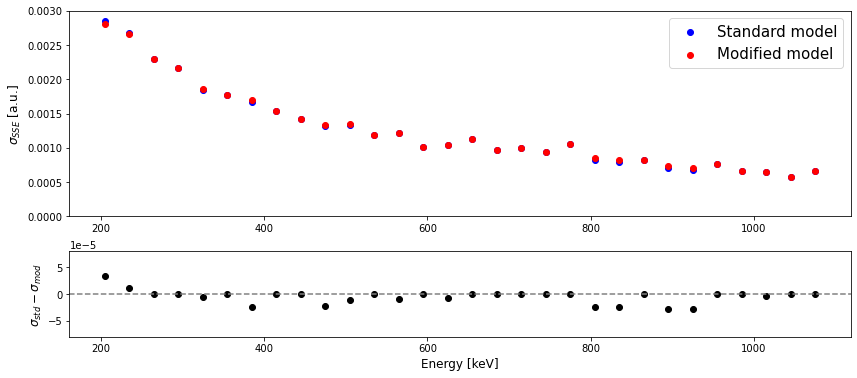

In [45]:
import numpy as np

fig = plt.figure(figsize=(14, 6))

grid = plt.GridSpec(14,8, hspace=0.8, wspace=0.0)
y = fig.add_subplot(grid[0:9, 0:])
y.scatter(xticks2, stdtot, marker='o', color='b', label='Standard model')
y.scatter(xticks2, stdtot2, marker='o', color='r', label='Modified model') 
y.legend(prop={'size': 15})
y.set_ylabel('$\u03C3_{SSE}$ [a.u.]', fontsize=12)
y.set_ylim(0.0, 0.003)

x = fig.add_subplot(grid[10:, 0:])
x.scatter(xticks2, delta, color='black')
x.axhline(0, linestyle='--', color='grey')

x.set_ylim(-8e-5, 8e-5)
x.set_ylabel('$\u03C3_{std}-\u03C3_{mod}$', fontsize=12)
x.set_xlabel('Energy [keV]', fontsize=12)

plt.savefig('new_plots/ICsigma(run113)(newvsold)(sigma).pdf')
